In [114]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import os
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

### Load data

In [115]:
df = pd.read_csv('../../regioes/dadosFinais.csv', sep=';')
print(df.columns)
print(df['codLocation'].unique())

local = 1711115
df = df[df['codLocation'] == local]
df.head()

Index(['Avaliacoes Total', 'Avaliacoes Apartamentos', 'Avaliacoes Moradias',
       'Capital Divida Total', 'Capital Divida 3M', 'Capital Divida 6M',
       'Capital Divida 12M', 'Juros Totais', 'Capital Amortizado',
       'Unemployed population', 'Prestacao Media', 'Mês', 'Ano', 'mes', 'ano',
       '1 mês (Euribor)', '3 meses (Euribor)', '6 meses (Euribor)',
       '12 meses (Euribor)',
       'Número de beneficiários de subsídio de desemprego (milhares)-mensal',
       'Indicador coincidente para a atividade económica-Mensal-TVH',
       'Indicador coincidente para o consumo privado-Mensal-TVH',
       'Endividamento dos particulares-TVA', 'Endividamento dos particulares',
       'Endividamento dos particulares junto de empresas não financeiras',
       'Endividamento dos particulares junto do setor financeiro',
       'Endividamento dos particulares junto das administrações públicas',
       'Endividamento dos particulares junto de particulares',
       'Endividamento dos particul

,Avaliacoes Total,Avaliacoes Apartamentos,Avaliacoes Moradias,Capital Divida Total,Capital Divida 3M,Capital Divida 6M,Capital Divida 12M,Juros Totais,Capital Amortizado,Unemployed population,...,Date,moving_avg_price_sell,exp_moving_avg_price_sell,price_to_rent_ratio,propriedades_unicas_rent,propriedades_unicas_sell,moving_avg_price_rent,exp_moving_avg_price_rent,moving_avg_Reducao_sell,moving_avg_Reducao_rent
1317,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180401,202955.666667,185891.371583,202.568216,0.0,3.0,1104.000000,993.847679,44.333333,7.0
1318,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180408,169080.000000,160455.685792,200.624071,9.0,-2.0,890.666667,833.423840,24.333333,3.0
1319,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180415,134624.333333,147097.842896,194.956268,-2.0,-2.0,675.333333,759.711920,1.000000,0.0
1320,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180422,134935.000000,141571.421448,205.506042,0.0,3.0,673.666667,710.855960,1.666667,0.0
1321,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180429,134707.000000,137953.710724,207.629057,0.0,-4.0,665.000000,678.927980,3.000000,0.0


In [116]:
# Separar variáveis independentes (X) e dependente (y)
X = df.drop(columns=['Preço médio_sell'])

# y = df[['Date','Preço médio_sell']]
y = df['Preço médio_sell'] # drop the m2

train_size = 0.7
test_size = 0.2
valid_size = 0.1

total_size = len(df)
train_end = int(train_size * total_size)
test_end = int((train_size + test_size) * total_size)

X_train = X.iloc[:train_end]
X_test = X.iloc[train_end:test_end]
X_valid = X.iloc[test_end:]

y_train = y.iloc[:train_end]
y_test = y.iloc[train_end:test_end]
y_valid = y.iloc[test_end:]


print(f"Tamanho do conjunto de treinamento: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"Tamanho do conjunto de validação: {len(X_valid)}")

# Preparar dados para treino
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_valid_scaled = scaler_X.transform(X_valid)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1))


Tamanho do conjunto de treinamento: 231
Tamanho do conjunto de teste: 66
Tamanho do conjunto de validação: 34


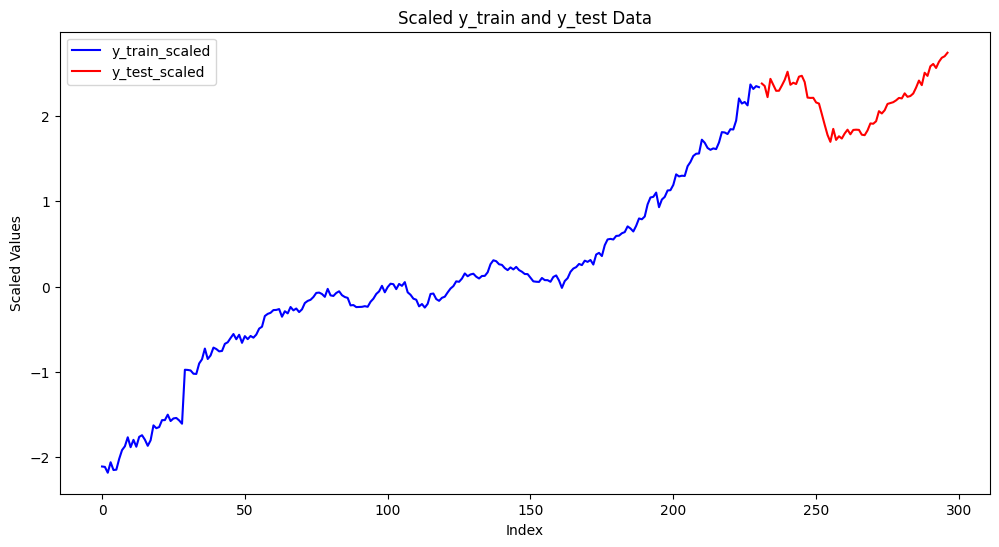

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_train_scaled, label='y_train_scaled', color='blue')
plt.plot(range(len(y_train_scaled), len(y_train_scaled) + len(y_test_scaled)), y_test_scaled, label='y_test_scaled', color='red')

plt.title('Scaled y_train and y_test Data')
plt.xlabel('Index')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

### Treino Dense neural network (MLP)

In [123]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

batch_size = 32
initial_learning_rate = 0.0009  # A learning rate inicial comum
steps_per_epoch = len(X_train_scaled) // batch_size  # Tamanho do batch (32) e tamanho do dataset
epochs = 650  # Total de épocas para treinamento
decay_steps = steps_per_epoch * 10  # Reduzir a learning rate após 10 épocas
decay_rate = 0.966  # Diminuir a learning rate em 5% a cada 10 épocas
activationF = 'tanh'  # Função de ativação comum

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True  # Usar degraus para ajustar a learning rate
)


model = Sequential()
model.add(Dense(192, activation=activationF, input_shape=(X_train.shape[1],),
                kernel_regularizer=regularizers.l2(0.006)))
model.add(BatchNormalization()) 
model.add(Dropout(0.25))

model.add(Dense(64, activation=activationF, kernel_regularizer=regularizers.l2(0.003)))
# model.add(Dense(64, activation='tanh'))
model.add(BatchNormalization()) 
model.add(Dense(batch_size, activation=activationF)) #, kernel_regularizer=regularizers.l2(0.003)))
model.add(Dense(1))



# # 3. Compilar o modelo
# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,  # quantas etapas para o decaimento
#     decay_rate=0.96,     # taxa de decaimento
#     staircase=True       # se true, a learning rate diminui em "degraus"
# )

def r2_scoree(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2


# Compilar o modelo com a learning rate adaptativa
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss=tf.keras.losses.Huber(), metrics=['mae', r2_scoree])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=100, 
                               restore_best_weights=True)

# 4. Treinar o modelo

history = model.fit(X_train_scaled, y_train_scaled, 
                    validation_data=(X_test_scaled, y_test_scaled), 
                    epochs=epochs, batch_size=batch_size,

                    callbacks=[early_stopping]
                    )


Epoch 1/650


c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.7470 - mae: 1.1996 - r2_scoree: -1.5069 - val_loss: 2.2843 - val_mae: 1.8479 - val_r2_scoree: -4903.8735
Epoch 2/650
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0936 - mae: 0.4509 - r2_scoree: 0.6343 - val_loss: 1.7819 - val_mae: 1.3530 - val_r2_scoree: -3701.9788
Epoch 3/650
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0435 - mae: 0.3954 - r2_scoree: 0.7539 - val_loss: 1.8965 - val_mae: 1.4780 - val_r2_scoree: -4560.9204
Epoch 4/650
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0111 - mae: 0.3551 - r2_scoree: 0.7562 - val_loss: 1.7015 - val_mae: 1.2880 - val_r2_scoree: -4010.4268
Epoch 5/650
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9688 - mae: 0.2761 - r2_scoree: 0.8361 - val_loss: 1.6519 - val_mae: 1.2386 - val_r2_scoree: -4147.9858
Epoch 6/650
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9442 - mae: 0.2602 - r2_scoree: 0.8891 - val_loss: 1.7077 - val_mae: 1.3039 - val_r2_scoree: -4641.9336
Epoch 7/650
8/8 ━━━━━━━━━━━━━━━━

### Metricas

In [61]:
def calcular_metricas(y_real, y_pred, conjunto):
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    acuracia = (1 - (mae / np.mean(y_real))) * 100
    print(f"{conjunto}: MAE: {mae:.2f}, R²: {r2:.2f}, MSE: {mse:.2f}, Acurácia: {acuracia:.2f}%")
    return mae, r2, mse, acuracia

In [124]:
y_pred_scaled_test = model.predict(X_test_scaled)
y_pred_scaled_train = model.predict(X_train_scaled)

y_pred_test = scaler_y.inverse_transform(y_pred_scaled_test)
y_test_real = scaler_y.inverse_transform(y_test_scaled)
y_pred_train = scaler_y.inverse_transform(y_pred_scaled_train)
y_train_real = scaler_y.inverse_transform(y_train_scaled)

mae_train, r2_train, mse_train, acuracia_train = calcular_metricas(y_train_real, 
                                                                   y_pred_train, 
                                                                   "Treino")

mae_test, r2_test, mse_test, acuracia_test = calcular_metricas(y_test_real, 
                                                               y_pred_test, 
                                                               "Teste")


# Treino: MAE: 698.41, R²: 1.00, MSE: 757757.99, Acurácia: 99.60%
# Teste: MAE: 2335.73, R²: 0.67, MSE: 9264346.26, Acurácia: 98.92%

# Treino: MAE: 1015.19, R²: 1.00, MSE: 1717047.37, Acurácia: 99.42%
# Teste: MAE: 2365.07, R²: 0.66, MSE: 9709691.80, Acurácia: 98.90%

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
Treino: MAE: 744.24, R²: 1.00, MSE: 891864.21, Acurácia: 99.57%
Teste: MAE: 2908.25, R²: 0.46, MSE: 15090628.78, Acurácia: 98.65%


dict_keys(['loss', 'mae', 'r2_scoree', 'val_loss', 'val_mae', 'val_r2_scoree'])


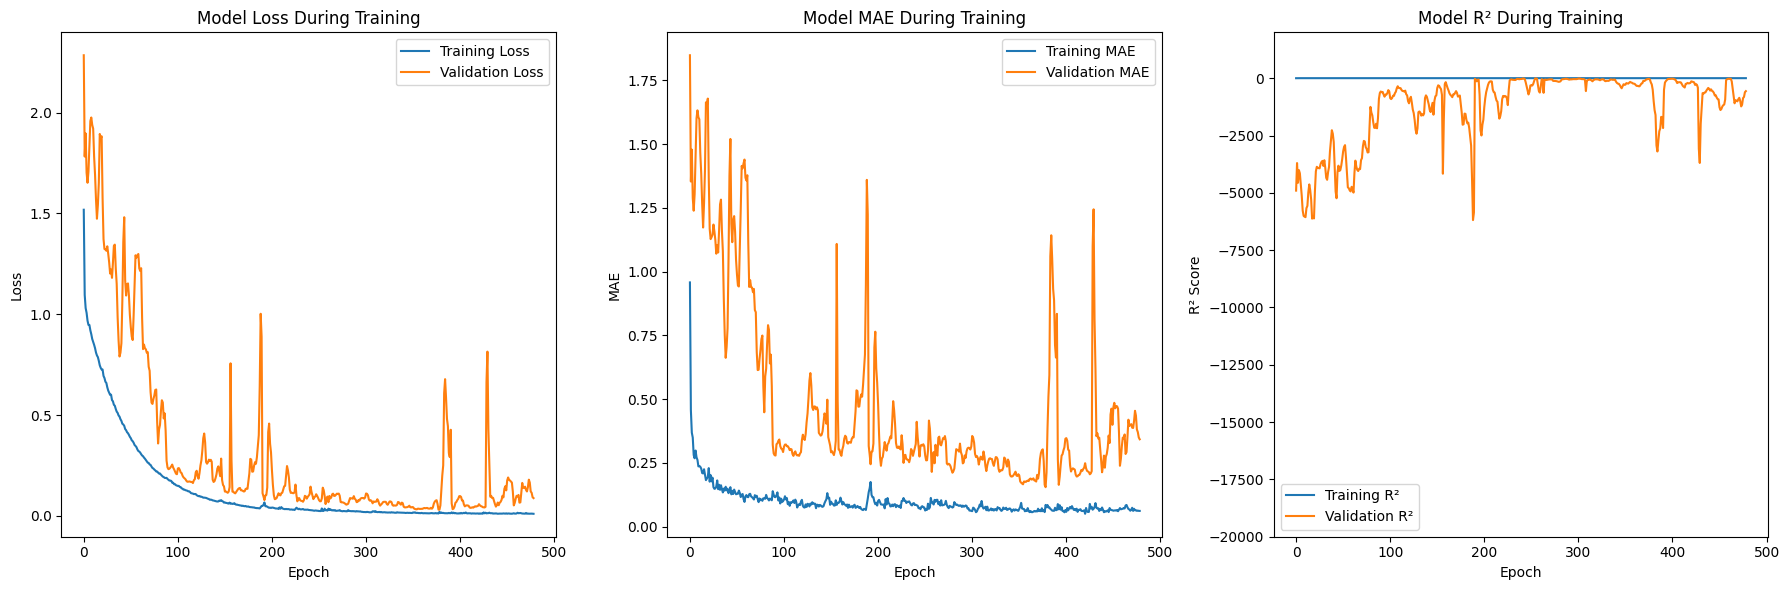

In [131]:
history_dict = history.history
print(history_dict.keys())

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loss
axs[0].plot(history_dict['loss'], label='Training Loss')
axs[0].plot(history_dict['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss During Training')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# MAE
axs[1].plot(history_dict['mae'], label='Training MAE')
axs[1].plot(history_dict['val_mae'], label='Validation MAE')
axs[1].set_title('Model MAE During Training')
axs[1].set_ylabel('MAE')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# R² Score
axs[2].plot(history_dict['r2_scoree'], label='Training R²')
axs[2].plot(history_dict['val_r2_scoree'], label='Validation R²')
axs[2].set_title('Model R² During Training')
axs[2].set_ylabel('R² Score')
axs[2].set_xlabel('Epoch')
axs[2].set_ylim(-20000, 2000) 
axs[2].legend()

plt.tight_layout()
plt.show()

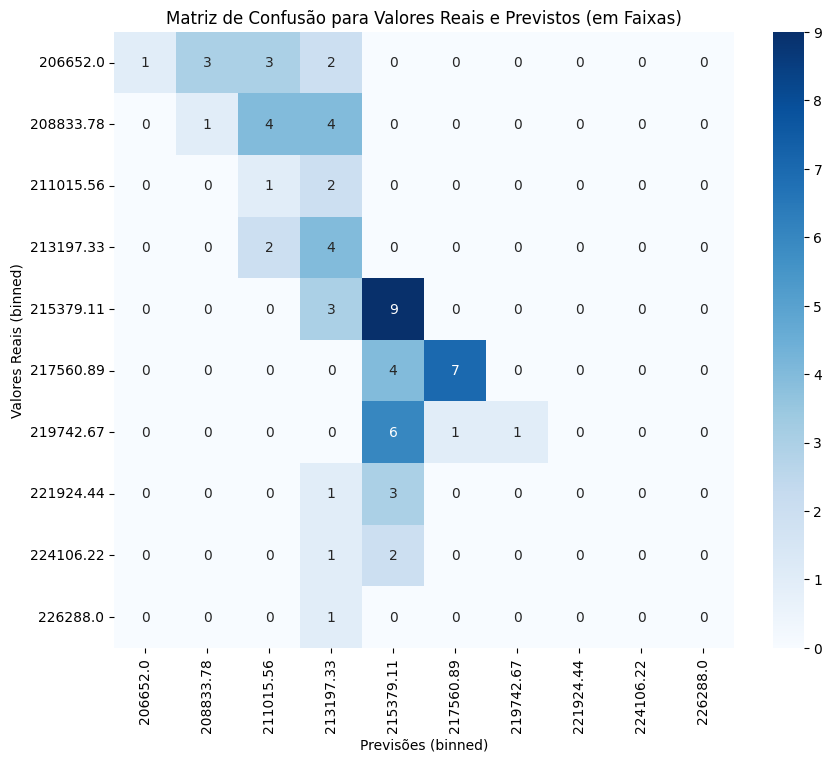

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

n_bins = 10

min_val = min(min(y_test), min(y_pred_test))
max_val = max(max(y_test), max(y_pred_test))

bins = np.linspace(min_val, max_val, n_bins)

y_test_binned = np.digitize(y_test, bins)
y_pred_binned = np.digitize(y_pred_test, bins)

conf_matrix = confusion_matrix(y_test_binned, y_pred_binned, labels=range(1, n_bins+1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=bins.round(2), yticklabels=bins.round(2))
plt.title('Matriz de Confusão para Valores Reais e Previstos (em Faixas)')
plt.xlabel('Previsões (binned)')
plt.ylabel('Valores Reais (binned)')
plt.show()

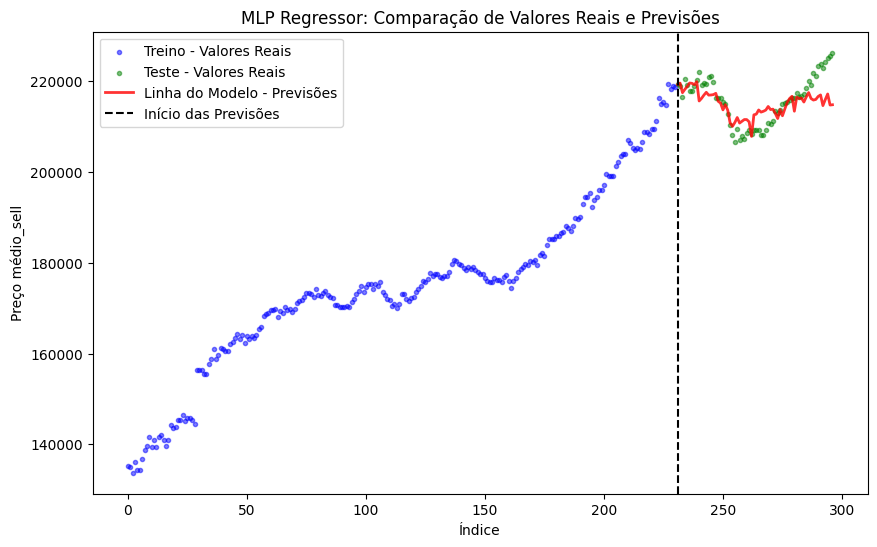

In [133]:
train_indices = range(len(y_train))
test_indices = range(len(y_train), len(y_train) + len(y_test))

plt.figure(figsize=(10, 6))
plt.scatter(train_indices, y_train, color='blue', label='Treino - Valores Reais', 
            alpha=0.5, marker='.')

plt.scatter(test_indices, y_test, color='green', label='Teste - Valores Reais', 
            alpha=0.5, marker='.')

plt.plot(test_indices, y_pred_test[:len(y_test)], color='red', 
         label='Linha do Modelo - Previsões', alpha=0.8, linewidth=2)

plt.axvline(x=len(y_train), color='black', linestyle='--', label='Início das Previsões')

plt.title('MLP Regressor: Comparação de Valores Reais e Previsões')
plt.xlabel('Índice')
plt.ylabel('Preço médio_sell')
plt.legend()

# Exibir o gráfico
# plt.grid(True)
plt.show()

In [134]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df

,Avaliacoes Total,Avaliacoes Apartamentos,Avaliacoes Moradias,Capital Divida Total,Capital Divida 3M,Capital Divida 6M,Capital Divida 12M,Juros Totais,Capital Amortizado,Unemployed population,...,Date,moving_avg_price_sell,exp_moving_avg_price_sell,price_to_rent_ratio,propriedades_unicas_rent,propriedades_unicas_sell,moving_avg_price_rent,exp_moving_avg_price_rent,moving_avg_Reducao_sell,moving_avg_Reducao_rent
0,0.018907,-0.058319,1.734036,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.509704,1.522042,0.607364,-1.331472,-0.125820,-0.097072,7.394434,5.608861,3.394032,2.333235
1,0.018907,-0.058319,1.734036,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.509171,-0.312236,-0.791344,-1.426681,1.412885,-0.388665,2.774553,1.719046,0.721232,0.342553
2,0.018907,-0.058319,1.734036,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.508638,-2.177919,-1.525892,-1.704247,-0.467755,-0.388665,-1.888639,-0.068255,-2.397035,-1.150460
3,0.018907,-0.058319,1.734036,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.508105,-2.161097,-1.829789,-1.187599,-0.125820,-0.097072,-1.924732,-1.252871,-2.307942,-1.150460
4,0.018907,-0.058319,1.734036,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.507572,-2.173442,-2.028727,-1.083630,-0.125820,-0.505303,-2.112414,-2.027032,-2.129755,-1.150460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,1.310053,1.305768,0.216755,2.242721,1.907956,1.980412,1.946246,0.795205,1.874274,-1.384726,...,1.560924,2.178019,2.193671,1.554049,1.412885,0.194522,1.092628,1.266839,-0.615168,-0.652789
227,1.141643,1.170487,-0.541886,2.380235,1.950648,2.016076,2.022116,2.444149,1.776298,-0.993917,...,1.566711,2.253807,2.318894,2.055961,0.216114,0.252841,1.157595,1.172592,-0.882448,-0.486899
228,1.141643,1.170487,-0.541886,2.380235,1.950648,2.016076,2.022116,2.444149,1.776298,-0.993917,...,1.567244,2.305536,2.354204,2.061691,-1.151624,-0.446984,1.034880,1.076974,-0.615168,-0.652789
229,1.141643,1.170487,-0.541886,2.380235,1.950648,2.016076,2.022116,2.444149,1.776298,-0.993917,...,1.567777,2.382154,2.389125,2.099991,0.387082,-1.729996,0.904945,1.029165,-0.926995,-0.818679


#### Dados de validacao

In [135]:
y_valid_pred_scaled = model.predict(X_valid_scaled)
y_valid_pred = scaler_y.inverse_transform(y_valid_pred_scaled)
y_valid_real = scaler_y.inverse_transform(y_valid_scaled)

mae_valid, r2_valid, mse_valid, acc_valid = calcular_metricas(y_valid_real, 
                                                              y_valid_pred, 
                                                              "Validação")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Validação: MAE: 15982.96, R²: -17.25, MSE: 265674743.73, Acurácia: 93.03%


### Results

In [136]:
results = { 
    'Conjunto': ['Treino', 'Teste', 'Validação'],
    'MAE': [mae_train, mae_test, mae_valid],
    'R²': [r2_train, r2_test, r2_valid],
    'MSE': [mse_train, mse_test, mse_valid],
    'Acurácia (%)': [acuracia_train, acuracia_test, acc_valid]
}

results_df = pd.DataFrame(results)
results_df

,Conjunto,MAE,R²,MSE,Acurácia (%)
0,Treino,744.242492,0.997477,8.918642e+05,99.574153
1,Teste,2908.249527,0.464215,1.509063e+07,98.652806
2,Validação,15982.959099,-17.253420,2.656747e+08,93.026570


In [137]:
import os
import json

def salvar_resultados_modelo(modelo_nome, localizacao,resultados_df):
    # Criar estrutura para salvar
    results_dict = resultados_df.to_dict(orient='records')
    results_dict_with_model = {
        "Modelo": modelo_nome,
        "Localização": localizacao,
        "Resultados": results_dict
    }

    # Caminho do diretório e do arquivo JSON
    directory = "modelos"
    json_filename = os.path.join(directory, 'resultadosModelos.json')

    # Criar o diretório se não existir
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Verificar se o arquivo já existe
    if os.path.exists(json_filename):
        with open(json_filename, 'r') as json_file:
            existing_data = json.load(json_file)
    else:
        existing_data = []

    # Adicionar os novos resultados
    existing_data.append(results_dict_with_model)

    # Salvar de volta no arquivo JSON
    with open(json_filename, 'w') as json_file:
        json.dump(existing_data, json_file, indent=4)

    print(f"Dados salvos e adicionados ao arquivo {json_filename}")


salvar_resultados_modelo("MLP", local, results_df)

Dados salvos e adicionados ao arquivo modelos\resultadosModelos.json
